In [1]:
import pickle
from copy import deepcopy
from utils_syninf import *
from utils_num import *

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dython.nominal import associations
from sklearn.preprocessing import quantile_transform


plt.style.use("bmh")

In [2]:
def plot_distribution(
    df_list: List[pd.DataFrame], column: str, df_names_list: Optional[List[str]] = None
):
    """Plot the distribution of a specific column from a list of dataframes."""

    if pd.api.types.is_numeric_dtype(df_list[0][column]):
        # If the column is numeric, plot a histogram
        # plt.figure(figsize=(12, 6))

        for i, temp_df in enumerate(df_list):
            sns.histplot(
                temp_df[column],
                label=f"{df_names_list[i]} {column}",
                kde=True,
                stat="density",
            )

        plt.legend()
        plt.title(f"Distribution of {column}")
        plt.show()

    elif pd.api.types.is_categorical_dtype(
        df_list[0][column]
    ) or pd.api.types.is_object_dtype(df_list[0][column]):
        # If the column is categorical, plot a bar chart
        # plt.figure(figsize=(12, 6))

        pivot_df = pd.DataFrame(
            data={
                column: sum([temp_df[column].to_list() for temp_df in df_list], []),
                "dataset": sum(
                    [
                        [df_names_list[i]] * len(temp_df)
                        for i, temp_df in enumerate(df_list)
                    ],
                    [],
                ),
            }
        )

        count_df = pivot_df.filter([column, "dataset"]).pivot_table(
            index=[column], aggfunc="size", columns="dataset"
        )
        prop_df = count_df.div(count_df.sum(axis=0), axis=1)
        prop_df.sort_values(by=df_names_list[0]).plot.bar()

        plt.legend()
        plt.title(f"Distribution of {column}")
        plt.show()


def compare_distributions(
    df_list: List[pd.DataFrame], df_names_list: Optional[List[str]] = None
):
    """
    Compare distributions of all columns between a list of dataframes with the same columns. One by one plot.
    """
    if df_names_list is None:
        df_names_list = [f"DataFrame{i}" for i in range(len(df_list))]

    for column in df_list[0].columns:
        plot_distribution(df_list, column, df_names_list)


def compare_distributions_grid(
    df_list: List[pd.DataFrame],
    df_names_list: Optional[List[str]] = None,
    nrows: int = 1,
    ncols: int = 1,
):
    """
    Compare distributions of all columns between a list of dataframes with the same columns. Plot in a grid.
    """
    if df_names_list is None:
        df_names_list = [f"DataFrame{i}" for i in range(len(df_list))]

    fig, axs = plt.subplots(nrows, ncols, figsize=(8 * ncols, 5 * nrows))
    axs = axs.ravel()

    df1 = df_list[0]
    for i, column in enumerate(df1.columns):
        ax = axs[i]

        temp_df = pd.DataFrame(
            data={
                column: sum([temp_df[column].to_list() for temp_df in df_list], []),
                "dataset": sum(
                    [
                        [df_names_list[i]] * len(temp_df)
                        for i, temp_df in enumerate(df_list)
                    ],
                    [],
                ),
            }
        )

        if pd.api.types.is_numeric_dtype(df1[column]):
            sns.histplot(
                data=temp_df,
                x=column,
                hue="dataset",
                ax=ax,
                stat="density",
                kde=True,
                common_norm=False,
            )

            ax.set_title(f"Distribution of {column}")
            ax.set_xlabel("")

        elif pd.api.types.is_categorical_dtype(
            df1[column]
        ) or pd.api.types.is_object_dtype(df1[column]):
            # If the column is categorical, plot a bar chart
            # plt.figure(figsize=(12, 6))

            count_df = temp_df.filter([column, "dataset"]).pivot_table(
                index=[column], aggfunc="size", columns="dataset"
            )
            count_df = count_df[df_names_list]
            
            prop_df = count_df.div(count_df.sum(axis=0), axis=1)
            prop_df.sort_values(by=df_names_list[0]).plot(ax=ax, kind="bar")

            ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

            category_size = len(temp_df[column].value_counts())
            if category_size <= 10:
                labelsize = 10
            elif category_size <= 20:
                labelsize = 8
            else:
                labelsize = 6
            ax.xaxis.set_tick_params(labelsize=labelsize)

            ax.set_title(f"Distribution of {column}")
            ax.set_xlabel("")

    i += 1
    while i < len(axs):
        axs[i].set_visible(False)
        i += 1

    # set the spacing between subplots
    plt.subplots_adjust(
        # left  = 0.125,  # the left side of the subplots of the figure
        # right = 0.9,    # the right side of the subplots of the figure
        # bottom = 0.1,   # the bottom of the subplots of the figure
        # top = 0.9,      # the top of the subplots of the figure
        # wspace = 0.2,   # the amount of width reserved for blank space between subplots
        hspace=0.45,  # the amount of height reserved for white space between subplots
    )


def heatmap_correlation(
    df1: pd.DataFrame, df2: pd.DataFrame, df1_name="df1", df2_name="df2"
):
    """Correlation heatmap and absolute difference between two dataframes of mixed-type columns."""
    true_corr = associations(
        df1,
        theil_u=True,
        annot=False,
        cmap="Blues",
        plot=False,
        nan_strategy="drop_samples",
    )["corr"]
    fake_corr = associations(
        df2,
        theil_u=True,
        annot=False,
        cmap="Blues",
        plot=False,
        nan_strategy="drop_samples",
    )["corr"]
    diff_corr = np.abs(true_corr - fake_corr)
    # heatmaps
    sns.set(rc={"axes.facecolor": "white", "figure.facecolor": "white"})
    cmap = sns.color_palette("ch:s=.25,rot=-.25", as_cmap=True, n_colors=100)

    kwargs = {
        "cmap": cmap,
        "annot": False,
        "xticklabels": False,
        "yticklabels": False,
        "cbar": False,
        "square": True,
        "vmin": 0,
        "vmax": 1,
    }

    plt.subplots(figsize=(40, 20))

    ax1 = plt.subplot(1, 3, 1)
    img = sns.heatmap(true_corr, **kwargs, ax=ax1)
    ax1.set_title(df1_name, weight="bold", fontsize=30)

    ax2 = plt.subplot(1, 3, 2)
    sns.heatmap(fake_corr, **kwargs, ax=ax2)
    ax2.set_title(df2_name, weight="bold", fontsize=30)

    ax3 = plt.subplot(1, 3, 3)
    sns.heatmap(diff_corr, **kwargs, ax=ax3)
    ax3.set_title("Absolute Difference", weight="bold", fontsize=30)

    mappable = img.get_children()[0]
    cbar = plt.colorbar(
        mappable, ax=[ax1, ax2, ax3], orientation="horizontal", pad=0.05
    )
    cbar.ax.tick_params(labelsize=30)

# Adult dataset

In [3]:
dataset_name = "adult"
dataset_dir = os.path.join(TDDPM_DIR, f"data/{dataset_name}")

num_features_list = [
    "age",
    "fnlwgt",
    "educationl-num",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
]

cat_features_list = [
    "workclass",
    "education",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "gender",
    "native-country",
]

y_feature = "income"  # <= 50K or > 50K

is_y_cat = True

names_dict = {
    "num_features_list": num_features_list,
    "cat_features_list": cat_features_list,
    "y_feature": y_feature,
    "is_y_cat": is_y_cat,
}

pickle.dump(names_dict, open(os.path.join(dataset_dir, "names_dict.pkl"), "wb"))

## Sampling

In [3]:
pipeline_config_path = os.path.join(
    TDDPM_DIR, f"exp/{dataset_name}/ddpm_cb_best/config.toml"
)
ckpt_path = os.path.join(TDDPM_DIR, f"exp/{dataset_name}/ddpm_cb_best/model.pt")


num_samples = 1000
batch_size = num_samples
device = "cuda:0"



sample_dir = generate_sample(
    pipeline_config_path=pipeline_config_path,
    ckpt_path=ckpt_path,
    num_samples=num_samples,
    batch_size=batch_size,
    device=device,
)

mlp
Sample timestep    0
Discrete cols: [2]
Num shape:  (1000, 6)


In [6]:

mydf = concat_data(
    sample_dir, "train", num_features_list, cat_features_list, y_feature, is_y_cat
)

mydf

,income,age,fnlwgt,educationl-num,capital-gain,capital-loss,hours-per-week,workclass,education,marital-status,occupation,relationship,race,gender,native-country
0,1,31.0,231810.714758,13.0,0.0,0.0,40.0,Private,Bachelors,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States
1,1,45.0,137499.245044,9.0,3103.0,0.0,40.0,Private,HS-grad,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States
2,0,32.0,192488.633324,7.0,0.0,0.0,40.0,Private,11th,Never-married,Craft-repair,Not-in-family,White,Male,United-States
3,0,25.0,195129.291670,9.0,0.0,0.0,40.0,Private,HS-grad,Never-married,Machine-op-inspct,Not-in-family,White,Male,United-States
4,1,34.0,28632.444153,13.0,0.0,0.0,40.0,State-gov,Bachelors,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,40.0,164768.512652,11.0,7688.0,0.0,55.0,Private,Assoc-voc,Married-civ-spouse,Transport-moving,Husband,White,Male,United-States
996,0,36.0,123190.494251,9.0,0.0,0.0,40.0,Self-emp-not-inc,HS-grad,Never-married,Adm-clerical,Unmarried,White,Female,United-States
997,0,56.0,265937.120127,13.0,0.0,0.0,40.0,Private,Bachelors,Never-married,Exec-managerial,Unmarried,White,Male,United-States
998,0,56.0,223135.405472,9.0,0.0,0.0,40.0,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States


In [9]:
train_df = mydf[:800]
test_df = mydf[800:]
null_feature_names = ["workclass", "education", "gender"]

# full model
full_model = catboost_pred_model(
    train_df, test_df, num_features_list, cat_features_list, y_feature, is_y_cat
)
test_pool_full = catboost_prepare_pool(test_df, num_features_list, cat_features_list, y_feature)
pred_prob_full = full_model.predict(test_pool_full, prediction_type="Probability")
logloss_full = log_loss(test_pool_full.get_label(), pred_prob_full[:, 1])

# partial model
partial_model = catboost_pred_model(
    train_df, test_df, num_features_list, cat_features_list, y_feature, is_y_cat, null_feature_names
)
test_pool_partial = catboost_prepare_pool(
    test_df, num_features_list, cat_features_list, y_feature, null_feature_names
)
pred_prob_partial = partial_model.predict(
    test_pool_partial, prediction_type="Probability"
)
logloss_partial = log_loss(test_pool_partial.get_label(), pred_prob_partial[:, 1])


print(f"log loss of the full model: {logloss_full}")
print(f"log loss of the partial model: {logloss_partial}")

Learning rate set to 0.014891
0:	learn: 0.6786783	test: 0.6809955	best: 0.6809955 (0)	total: 72.1ms	remaining: 6m
1:	learn: 0.6671415	test: 0.6708790	best: 0.6708790 (1)	total: 79.8ms	remaining: 3m 19s
2:	learn: 0.6544850	test: 0.6590353	best: 0.6590353 (2)	total: 88.5ms	remaining: 2m 27s
3:	learn: 0.6413337	test: 0.6475921	best: 0.6475921 (3)	total: 96.7ms	remaining: 2m
4:	learn: 0.6298442	test: 0.6370210	best: 0.6370210 (4)	total: 105ms	remaining: 1m 45s
5:	learn: 0.6193351	test: 0.6273484	best: 0.6273484 (5)	total: 114ms	remaining: 1m 34s
6:	learn: 0.6089837	test: 0.6180218	best: 0.6180218 (6)	total: 121ms	remaining: 1m 25s
7:	learn: 0.5975482	test: 0.6085318	best: 0.6085318 (7)	total: 129ms	remaining: 1m 20s
8:	learn: 0.5870593	test: 0.5997253	best: 0.5997253 (8)	total: 139ms	remaining: 1m 17s
9:	learn: 0.5773779	test: 0.5912749	best: 0.5912749 (9)	total: 148ms	remaining: 1m 13s
10:	learn: 0.5668356	test: 0.5822320	best: 0.5822320 (10)	total: 155ms	remaining: 1m 10s
11:	learn: 0.55

In [10]:
blackbox_test_stat(test_df, full_model, partial_model, num_features_list, cat_features_list, y_feature, is_y_cat, null_feature_names)

-2.6016381124913615

## Training and fine-tuning

In [4]:
pipeline_config_path = os.path.join(
    TDDPM_DIR, f"exp/{dataset_name}/ddpm_cb_best/config.toml"
)
real_data_dir = os.path.join(TDDPM_DIR, f"data/{dataset_name}")
ckpt_path = os.path.join(TDDPM_DIR, f"exp/{dataset_name}/ddpm_cb_best/model.pt")

steps = 1000
lr = None
batch_size = None
device = "cuda:0"

train_dir = train_tabddpm(
    pipeline_config_path=pipeline_config_path,
    real_data_dir=real_data_dir,
    ckpt_path=ckpt_path,
    steps=steps,
    lr=lr,
    batch_size=batch_size,
    device=device,
)

[ 9 16  7 15  6  5  2 42]
108
{'num_classes': 2, 'is_y_cond': True, 'rtdl_params': {'d_layers': [256, 1024, 1024, 1024, 1024, 256], 'dropout': 0.0}, 'd_in': 108}
mlp
Loading model checkpoint from /home/liu00980/Documents/multimodal/tabular/tab-ddpm/exp/adult/ddpm_cb_best/model.pt
Step 500/1000 MLoss: 0.952 GLoss: 0.3433 Sum: 1.2953
Step 1000/1000 MLoss: 0.9295 GLoss: 0.3082 Sum: 1.2377


In [5]:
# generate samples from fine-tuned model
generate_sample(
    pipeline_config_path=pipeline_config_path,
    ckpt_path=os.path.join(os.getcwd(), train_dir, "model.pt"),
    num_samples=1000,
    batch_size=1000,
    device=device,
)

mlp
Sample timestep    0
Discrete cols: [2]
Num shape:  (1000, 6)


'ddpm_sample_test'

## Aggregate and split by Gender

In [4]:

train_df = concat_data(dataset_dir, split="train", **names_dict)
val_df = concat_data(dataset_dir, split="val", **names_dict)
test_df = concat_data(dataset_dir, split="test", **names_dict)

overall_df = pd.concat([train_df, val_df, test_df], axis=0)

overall_df

,income,age,fnlwgt,educationl-num,capital-gain,capital-loss,hours-per-week,workclass,education,marital-status,occupation,relationship,race,gender,native-country
0,0,32.0,228265.0,9.0,0.0,0.0,30.0,Private,HS-grad,Never-married,Handlers-cleaners,Own-child,White,Female,United-States
1,0,21.0,89154.0,7.0,0.0,0.0,42.0,Private,11th,Never-married,Other-service,Own-child,White,Male,El-Salvador
2,0,33.0,43716.0,10.0,0.0,0.0,4.0,State-gov,Some-college,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States
3,0,43.0,81243.0,13.0,0.0,1876.0,40.0,Private,Bachelors,Divorced,Tech-support,Not-in-family,White,Male,United-States
4,1,50.0,155574.0,14.0,7298.0,0.0,50.0,Self-emp-inc,Masters,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,0,39.0,215419.0,13.0,0.0,0.0,36.0,Private,Bachelors,Divorced,Prof-specialty,Not-in-family,White,Female,United-States
16277,0,64.0,321403.0,9.0,0.0,0.0,40.0,nan,HS-grad,Widowed,nan,Other-relative,Black,Male,United-States
16278,0,38.0,374983.0,13.0,0.0,0.0,50.0,Private,Bachelors,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States
16279,0,44.0,83891.0,13.0,5455.0,0.0,40.0,Private,Bachelors,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,United-States


In [5]:
male_df = overall_df[overall_df.gender == "Male"].drop(columns=["gender"])
female_df = overall_df[overall_df.gender == "Female"].drop(columns=["gender"])
print("Male:", male_df.shape)
print("Female:", female_df.shape)

Male: (32650, 14)
Female: (16192, 14)


In [6]:
# prepare data for tabddpm training

gender_names_dict = deepcopy(names_dict)
gender_names_dict["cat_features_list"].remove("gender")

temp_df = male_df.copy()
train_data_dir = os.path.join(TDDPM_DIR, "data/adult_male")
split = (0.999, 0.001, 0)

seed = 2023

train_data_dir = prepare_train_data(
    temp_df=temp_df,
    train_data_dir=train_data_dir,
    split=split,
    seed=seed,
    **gender_names_dict
)
print(train_data_dir)

pickle.dump(gender_names_dict, open(os.path.join(train_data_dir, "names_dict.pkl"), "wb"))


saved /home/liu00980/Documents/multimodal/tabular/tab-ddpm/data/adult_male/X_num_train.npy
saved /home/liu00980/Documents/multimodal/tabular/tab-ddpm/data/adult_male/X_cat_train.npy
saved /home/liu00980/Documents/multimodal/tabular/tab-ddpm/data/adult_male/y_train.npy
saved /home/liu00980/Documents/multimodal/tabular/tab-ddpm/data/adult_male/X_num_val.npy
saved /home/liu00980/Documents/multimodal/tabular/tab-ddpm/data/adult_male/X_cat_val.npy
saved /home/liu00980/Documents/multimodal/tabular/tab-ddpm/data/adult_male/y_val.npy
saved /home/liu00980/Documents/multimodal/tabular/tab-ddpm/data/adult_male/X_num_test.npy
saved /home/liu00980/Documents/multimodal/tabular/tab-ddpm/data/adult_male/X_cat_test.npy
saved /home/liu00980/Documents/multimodal/tabular/tab-ddpm/data/adult_male/y_test.npy
/home/liu00980/Documents/multimodal/tabular/tab-ddpm/data/adult_male


In [24]:
# Pre-train the model using female twin 1 data

pipeline_config_path = os.path.join(
    TDDPM_DIR, f"exp/adult_male/ddpm_cb_best/config.toml"
)
temp_parent_dir = os.path.join(TDDPM_DIR, f"exp/adult_female_pretraining_twin1/ddpm_cb_best")
device = "cuda:0"


train_tabddpm(
    pipeline_config_path=pipeline_config_path,
    real_data_dir="/home/liu00980/Documents/multimodal/tabular/tab-ddpm/data/adult_female_pretraining_twin1",
    pipeline_dict_path="/home/liu00980/Documents/multimodal/tabular/tab-ddpm/exp/adult_male/ddpm_cb_best/pipeline_dict.joblib",
    temp_parent_dir=temp_parent_dir,
    device=device,
)

Loading numerical preprocessing pipeline from /home/liu00980/Documents/multimodal/tabular/tab-ddpm/exp/adult_male/ddpm_cb_best/pipeline_dict.joblib
Loading categorical preprocessing pipeline from /home/liu00980/Documents/multimodal/tabular/tab-ddpm/exp/adult_male/ddpm_cb_best/pipeline_dict.joblib
Use category sizes from the loaded pipeline: [ 9 16  7 15  6  5 41]
105
{'num_classes': 2, 'is_y_cond': True, 'rtdl_params': {'d_layers': [256, 1024, 1024, 1024, 1024, 256], 'dropout': 0.0}, 'd_in': 105}
mlp
Step 500/30000 MLoss: 1.2564 GLoss: 0.9876 Sum: 2.2439999999999998
Step 1000/30000 MLoss: 1.1481 GLoss: 0.8682 Sum: 2.0162999999999998
Step 1500/30000 MLoss: 1.0558 GLoss: 0.7408 Sum: 1.7966000000000002
Step 2000/30000 MLoss: 1.0135 GLoss: 0.6411 Sum: 1.6546
Step 2500/30000 MLoss: 0.98 GLoss: 0.6336 Sum: 1.6136
Step 3000/30000 MLoss: 0.9514 GLoss: 0.6214 Sum: 1.5728
Step 3500/30000 MLoss: 0.9481 GLoss: 0.6174 Sum: 1.5655000000000001
Step 4000/30000 MLoss: 0.9243 GLoss: 0.6048 Sum: 1.529100

'/home/liu00980/Documents/multimodal/tabular/tab-ddpm/exp/adult_female_pretraining_twin1/ddpm_cb_best'

In [7]:
# Pre-train the model using male-only data

pipeline_config_path = os.path.join(
    TDDPM_DIR, f"exp/{dataset_name}/ddpm_cb_best/config.toml"
)
temp_parent_dir = os.path.join(TDDPM_DIR, f"exp/{dataset_name}_male/ddpm_cb_best")
device = "cuda:0"

if not os.path.exists(temp_parent_dir):
    train_tabddpm(
        pipeline_config_path=pipeline_config_path,
        real_data_dir=train_data_dir,
        temp_parent_dir=temp_parent_dir,
        device=device,
    )

In [8]:
# Select a subset of female_df as inference sample
subset_size = 3000

seed = 2023
gender_names_dict = deepcopy(names_dict)
gender_names_dict["cat_features_list"].remove("gender")

female_df_subset = female_df.copy().sample(frac=1, random_state=seed)[:subset_size]
train_data_dir = os.path.join(TDDPM_DIR, f"data/{dataset_name}_female_{subset_size}")
split = (0.7, 0.2, 0.1)

train_data_dir = prepare_train_data(
    temp_df=female_df_subset,
    train_data_dir=train_data_dir,
    split=split,
    seed=seed,
    **gender_names_dict
)
print(train_data_dir)

pickle.dump(gender_names_dict, open(os.path.join(train_data_dir, "names_dict.pkl"), "wb"))

saved /home/liu00980/Documents/multimodal/tabular/tab-ddpm/data/adult_female_3000/X_num_train.npy
saved /home/liu00980/Documents/multimodal/tabular/tab-ddpm/data/adult_female_3000/X_cat_train.npy
saved /home/liu00980/Documents/multimodal/tabular/tab-ddpm/data/adult_female_3000/y_train.npy
saved /home/liu00980/Documents/multimodal/tabular/tab-ddpm/data/adult_female_3000/X_num_val.npy
saved /home/liu00980/Documents/multimodal/tabular/tab-ddpm/data/adult_female_3000/X_cat_val.npy
saved /home/liu00980/Documents/multimodal/tabular/tab-ddpm/data/adult_female_3000/y_val.npy
saved /home/liu00980/Documents/multimodal/tabular/tab-ddpm/data/adult_female_3000/X_num_test.npy
saved /home/liu00980/Documents/multimodal/tabular/tab-ddpm/data/adult_female_3000/X_cat_test.npy
saved /home/liu00980/Documents/multimodal/tabular/tab-ddpm/data/adult_female_3000/y_test.npy
/home/liu00980/Documents/multimodal/tabular/tab-ddpm/data/adult_female_3000


## Check model fine-tuned on Adult-female

In [50]:
# generate synthetic female sample on temporary working directory
synthetic_sample_dir = generate_sample(
    pipeline_config_path=f"{TDDPM_DIR}/exp/adult_female_{subset_size}_twin_1/ddpm_cb_best/config.toml",
    ckpt_path=f"{TDDPM_DIR}/exp/adult_female_{subset_size}_twin_1/ddpm_cb_best/model.pt",
    pipeline_dict_path=f"{TDDPM_DIR}/exp/adult_female_{subset_size}_twin_1/ddpm_cb_best/pipeline_dict.joblib",
    num_samples=1350,
    batch_size=1350,
    device="cuda:0",
)
fake_female_df_twin1 = concat_data(synthetic_sample_dir, **gender_names_dict)
fake_female_df_twin1["income"].cat.categories = ["0", "1"]


# compare with test set of twin_1 data
female_df_twin1_test = concat_data(
    f"{TDDPM_DIR}/data/adult_female_{subset_size}_twin_1",
    split="test",
    **gender_names_dict,
)

Loading numerical preprocessing pipeline from /home/liu00980/Documents/multimodal/tabular/tab-ddpm//exp/adult_female_3000_twin_1/ddpm_cb_best/pipeline_dict.joblib
Loading categorical preprocessing pipeline from /home/liu00980/Documents/multimodal/tabular/tab-ddpm//exp/adult_female_3000_twin_1/ddpm_cb_best/pipeline_dict.joblib
Use category sizes from the loaded pipeline: [ 9 16  7 15  6  5 41]
mlp
Sample timestep    0
Discrete cols: [2, 4]
Num shape:  (1350, 6)


### Marginal distribution

Loading numerical preprocessing pipeline from /home/liu00980/Documents/multimodal/tabular/tab-ddpm//exp/adult_female_3000_twin_1/ddpm_cb_best/pipeline_dict.joblib
Loading categorical preprocessing pipeline from /home/liu00980/Documents/multimodal/tabular/tab-ddpm//exp/adult_female_3000_twin_1/ddpm_cb_best/pipeline_dict.joblib
Use category sizes from the loaded pipeline: [ 9 16  7 15  6  5 41]
mlp


Sample timestep    0
Discrete cols: [2, 4]
Num shape:  (10000, 6)
Loading numerical preprocessing pipeline from /home/liu00980/Documents/multimodal/tabular/tab-ddpm//exp/adult_female_3000_twin_2/ddpm_cb_best/pipeline_dict.joblib
Loading categorical preprocessing pipeline from /home/liu00980/Documents/multimodal/tabular/tab-ddpm//exp/adult_female_3000_twin_2/ddpm_cb_best/pipeline_dict.joblib
Use category sizes from the loaded pipeline: [ 9 16  7 15  6  5 41]
mlp
Sample timestep    0
Discrete cols: [2, 4]
Num shape:  (10000, 6)


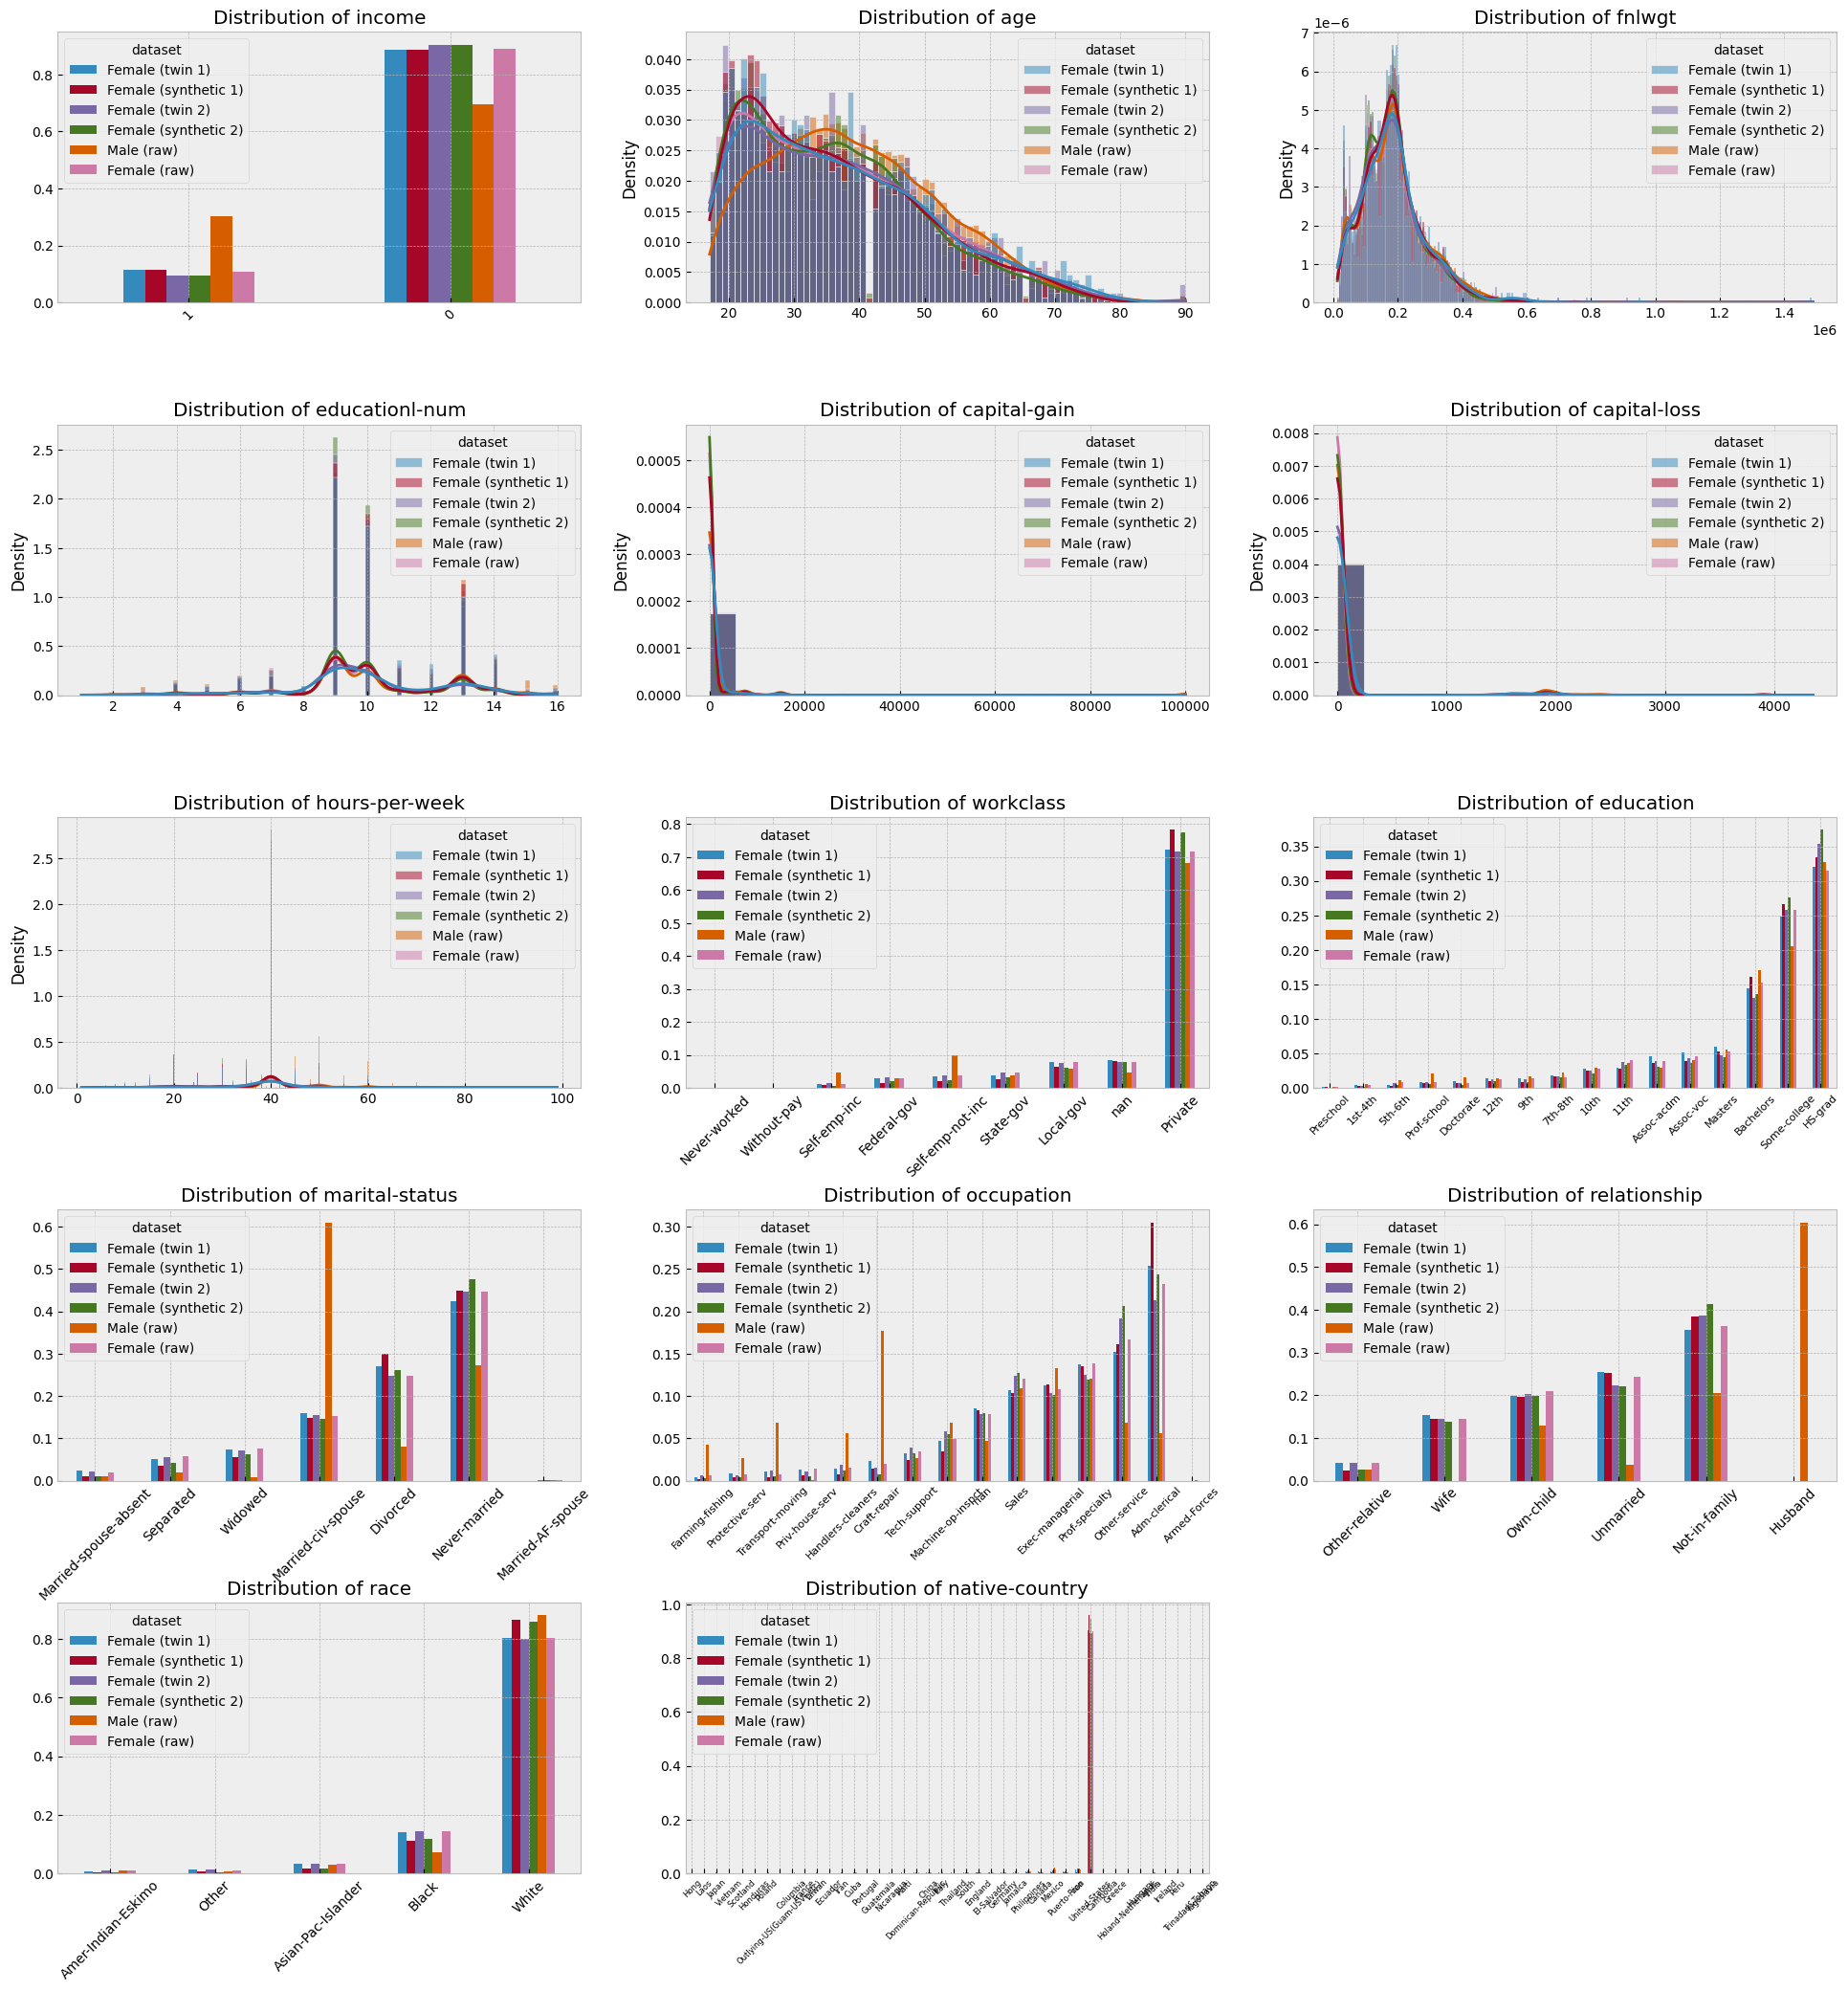

In [54]:
# For testing only

synthetic_size = 10000
synthetic_sample_dir = generate_sample(
    pipeline_config_path=f"{TDDPM_DIR}/exp/adult_female_{subset_size}_twin_1/ddpm_cb_best/config.toml",
    ckpt_path=f"{TDDPM_DIR}/exp/adult_female_{subset_size}_twin_1/ddpm_cb_best/model.pt",
    pipeline_dict_path=f"{TDDPM_DIR}/exp/adult_female_{subset_size}_twin_1/ddpm_cb_best/pipeline_dict.joblib",
    num_samples=synthetic_size,
    batch_size=synthetic_size,
    device="cuda:0",
)
fake_female_df_twin1 = concat_data(synthetic_sample_dir, **gender_names_dict)
fake_female_df_twin1["income"].cat.categories = ["0", "1"]


synthetic_sample_dir = generate_sample(
    pipeline_config_path=f"{TDDPM_DIR}/exp/adult_female_{subset_size}_twin_2/ddpm_cb_best/config.toml",
    ckpt_path=f"{TDDPM_DIR}/exp/adult_female_{subset_size}_twin_2/ddpm_cb_best/model.pt",
    pipeline_dict_path=f"{TDDPM_DIR}/exp/adult_female_{subset_size}_twin_2/ddpm_cb_best/pipeline_dict.joblib",
    num_samples=synthetic_size,
    batch_size=synthetic_size,
    device="cuda:0",
)
fake_female_df_twin2 = concat_data(synthetic_sample_dir, **gender_names_dict)
fake_female_df_twin2["income"].cat.categories = ["0", "1"]



female_df_twin1_test = concat_data(
    f"{TDDPM_DIR}/data/adult_female_{subset_size}_twin_1",
    split="test",
    **gender_names_dict,
)


female_df_twin2_test = concat_data(
    f"{TDDPM_DIR}/data/adult_female_{subset_size}_twin_2",
    split="test",
    **gender_names_dict,
)

df_list = [female_df_twin2_test, fake_female_df_twin1, female_df_twin1_test, fake_female_df_twin2, male_df]
df_names_list = ["Female (twin 1)", "Female (synthetic 1)", "Female (twin 2)", "Female (synthetic 2)", "Male (raw)"]
compare_distributions_grid(df_list, df_names_list, 5, 3)

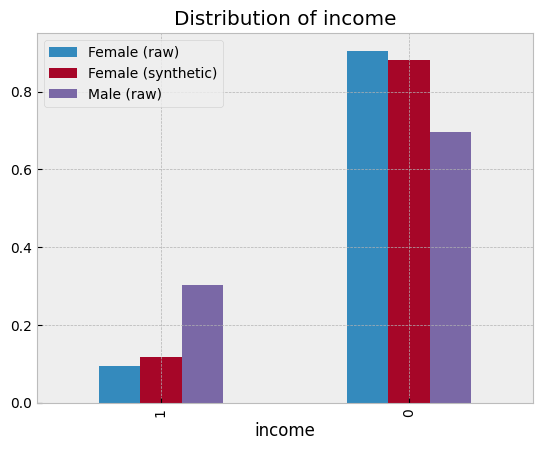

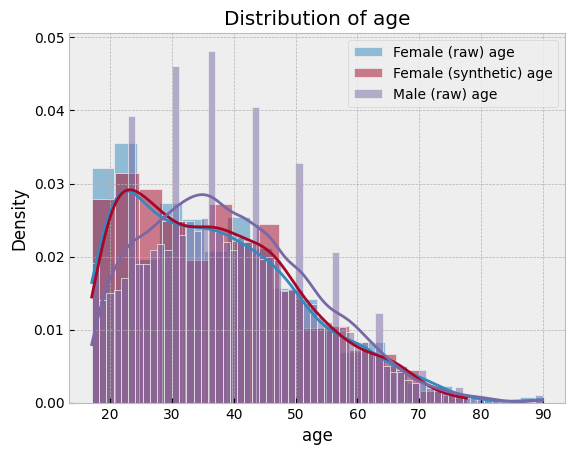

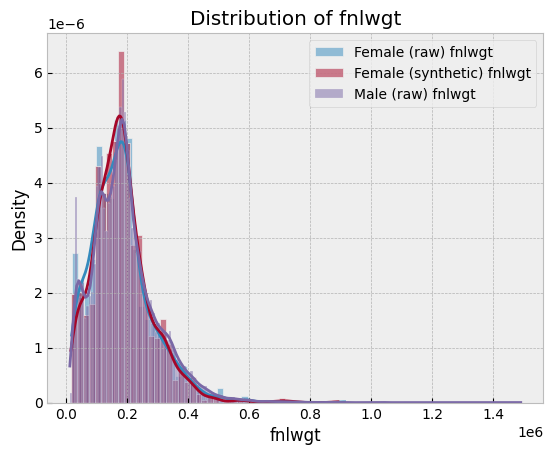

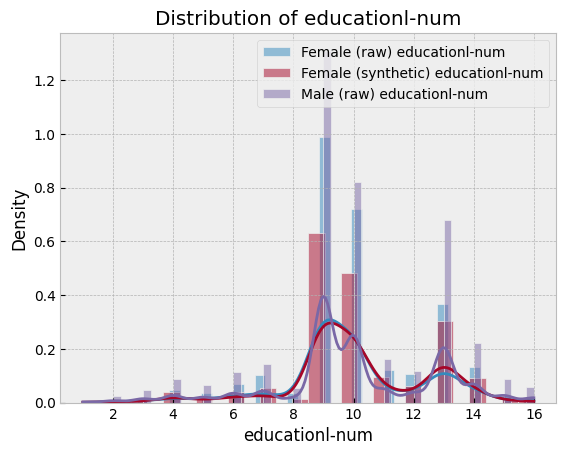

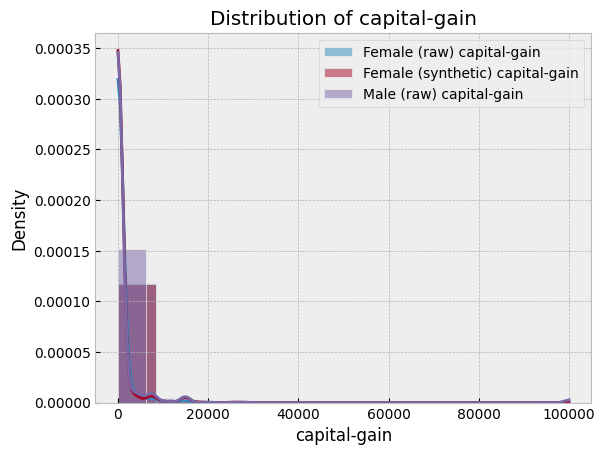

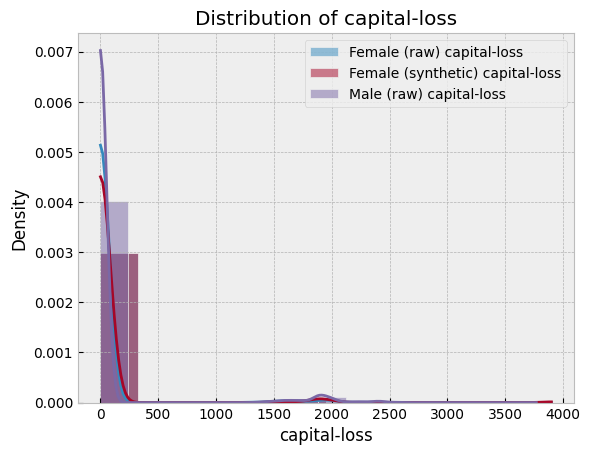

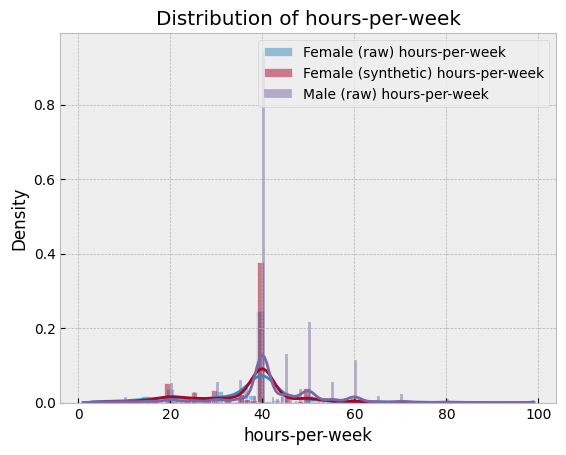

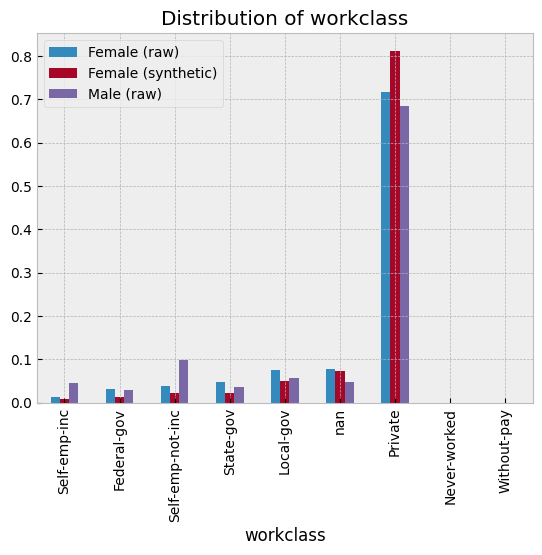

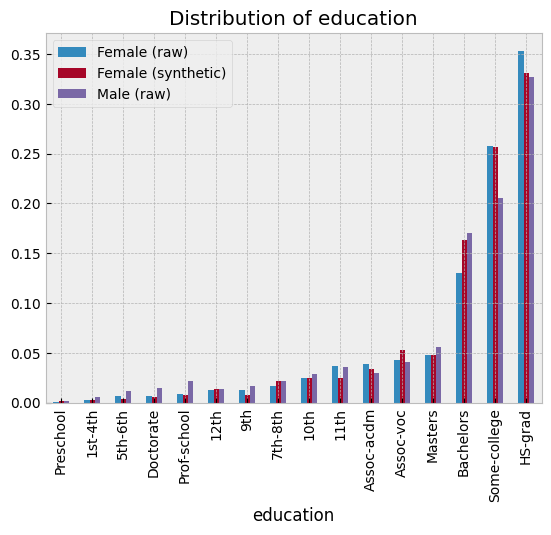

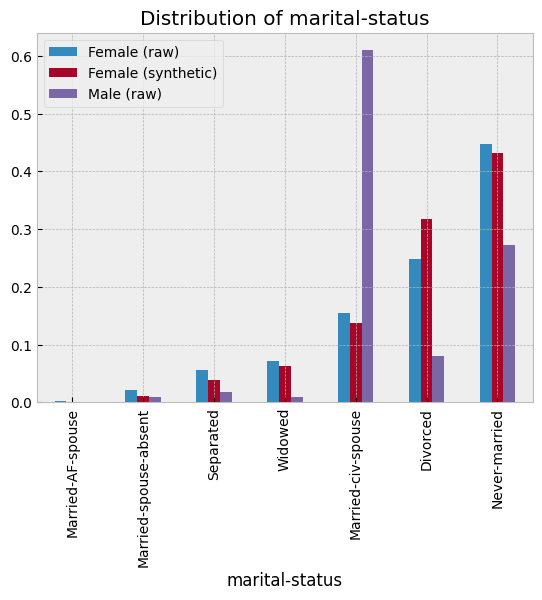

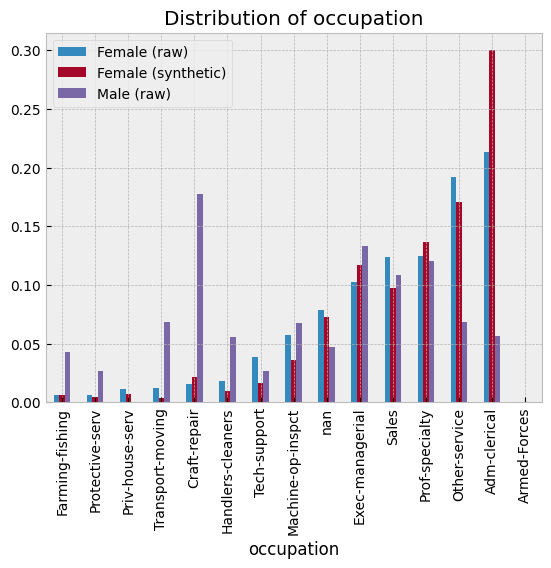

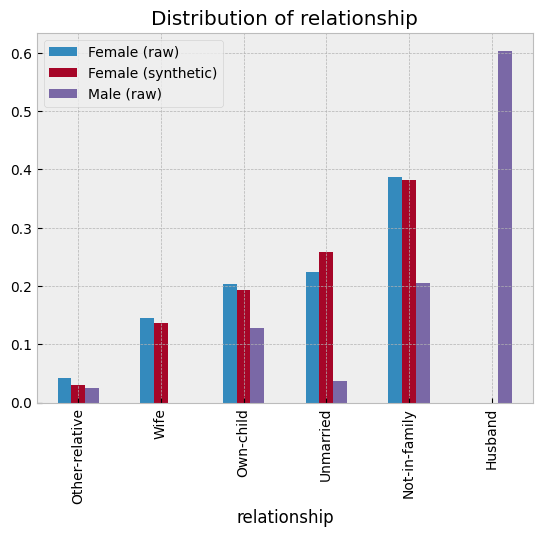

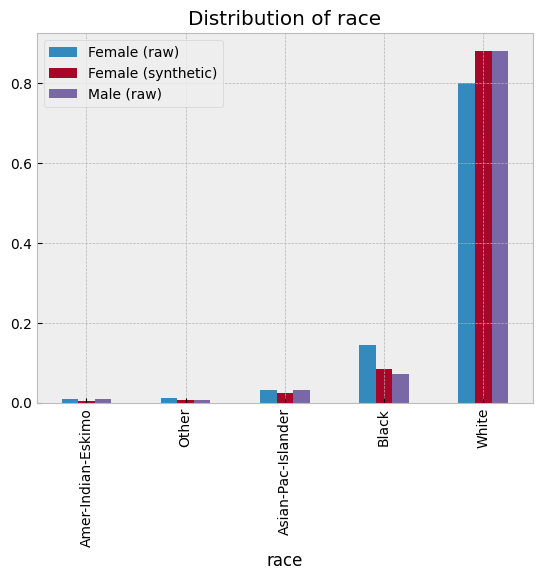

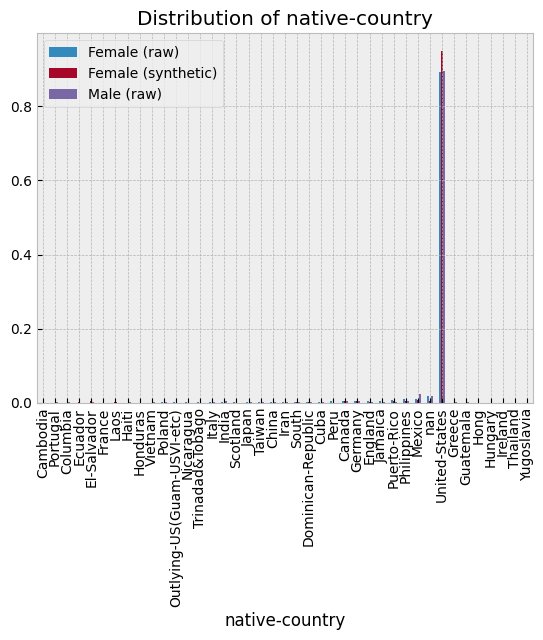

In [18]:

df_list = [female_df_twin1_test, fake_female_df_twin1, male_df]
df_names_list = ["Female (raw)", "Female (synthetic)", "Male (raw)"]
compare_distributions(df_list, df_names_list)

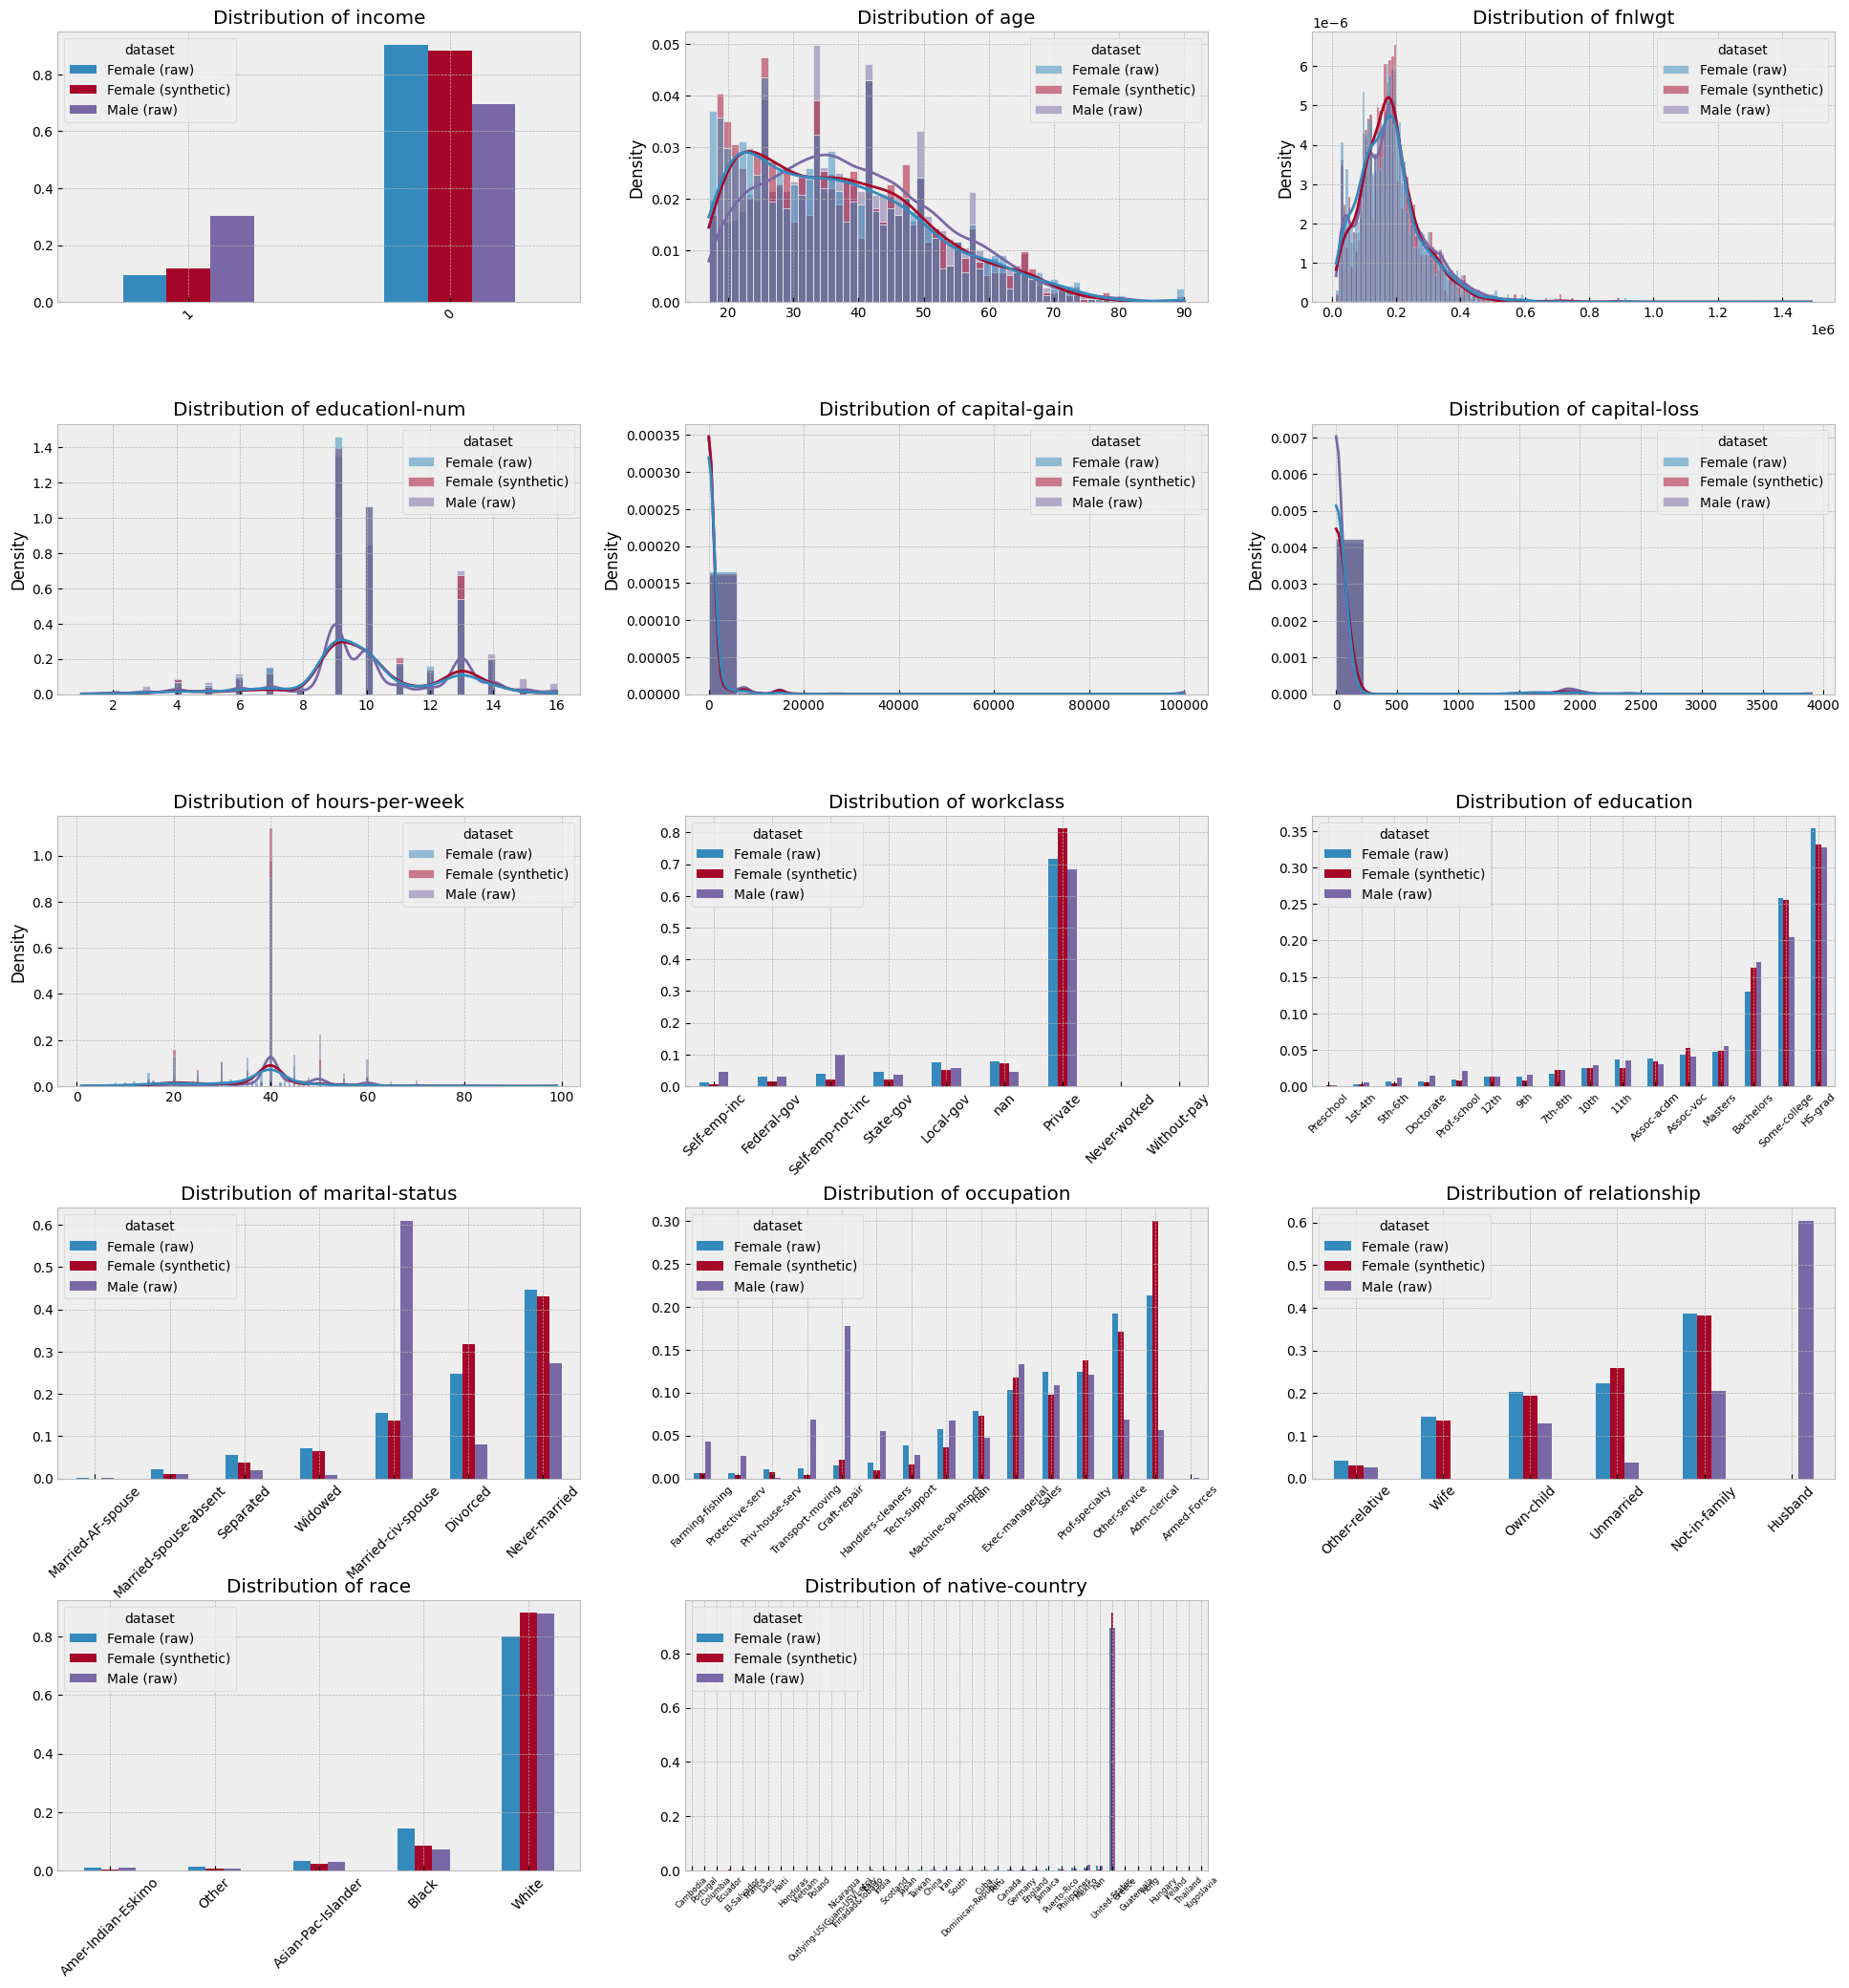

In [27]:

df_list = [female_df_twin1_test, fake_female_df_twin1, male_df]
df_names_list = ["Female (raw)", "Female (synthetic)", "Male (raw)"]
compare_distributions_grid(df_list, df_names_list, 5, 3)

### Pairwise correlation of mixed-type columns

/tmp/ipykernel_48333/1786341208.py:27: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(1, 3, 1)


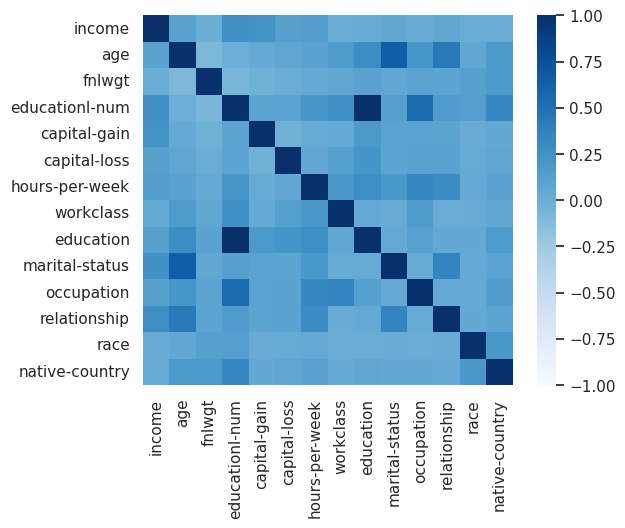

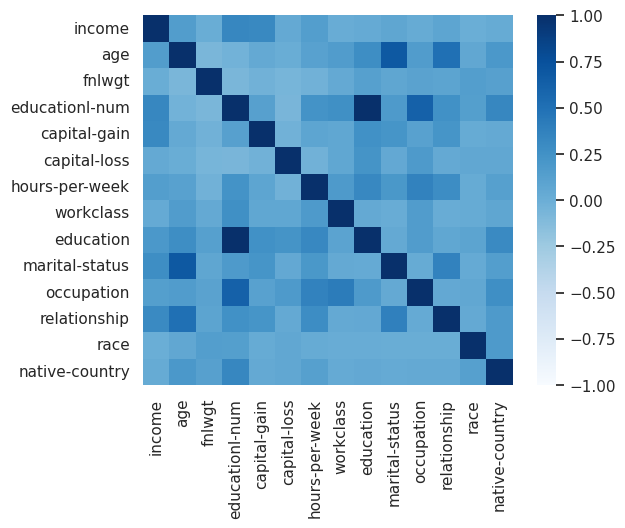

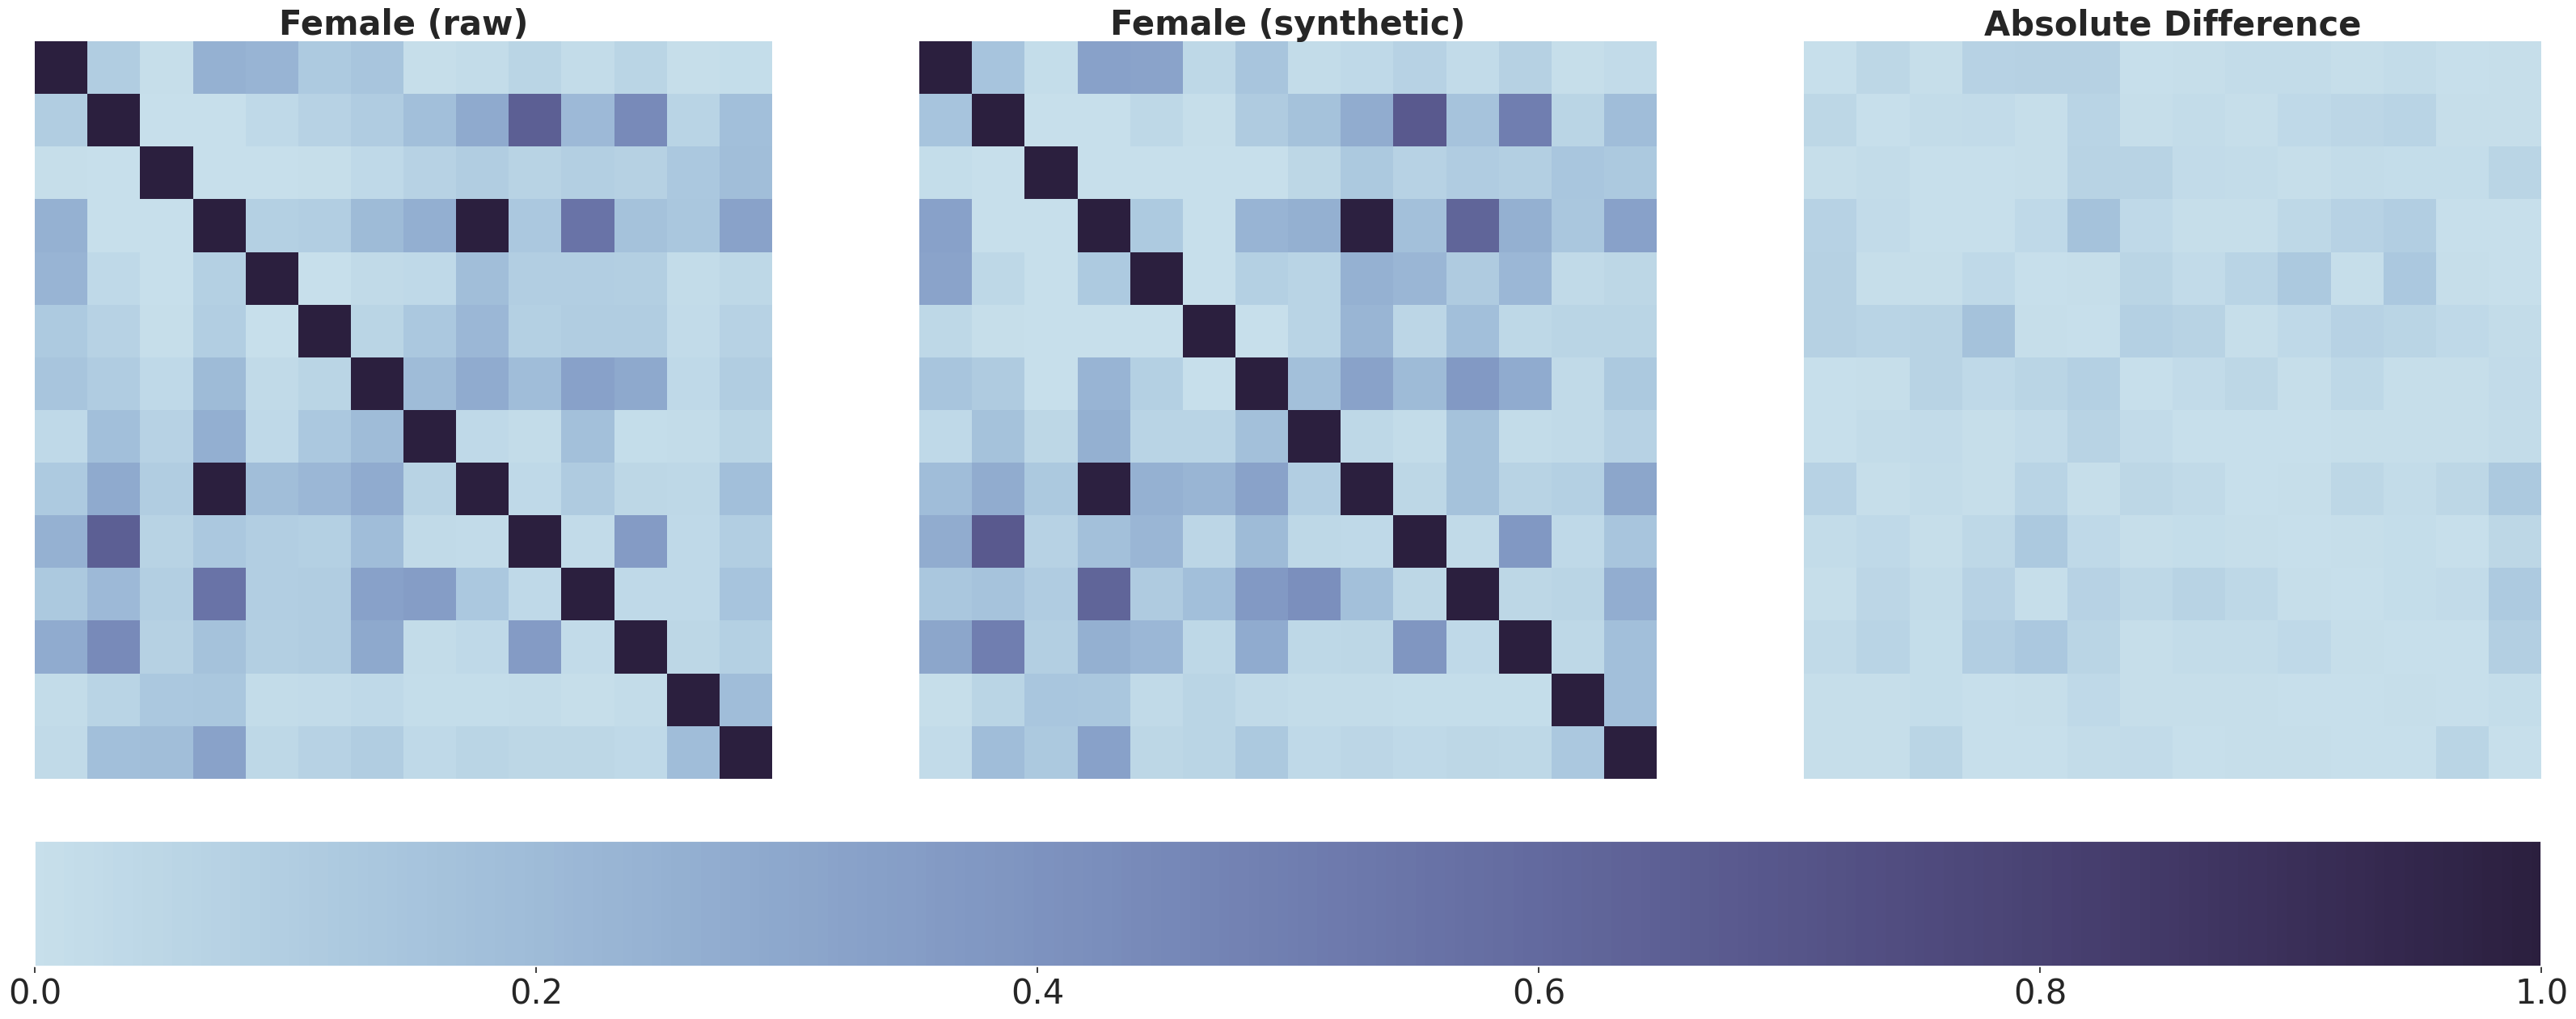

In [31]:
heatmap_correlation(female_df_twin1_test, fake_female_df_twin1, "Female (raw)", "Female (synthetic)")

/tmp/ipykernel_48333/1786341208.py:27: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(1, 3, 1)


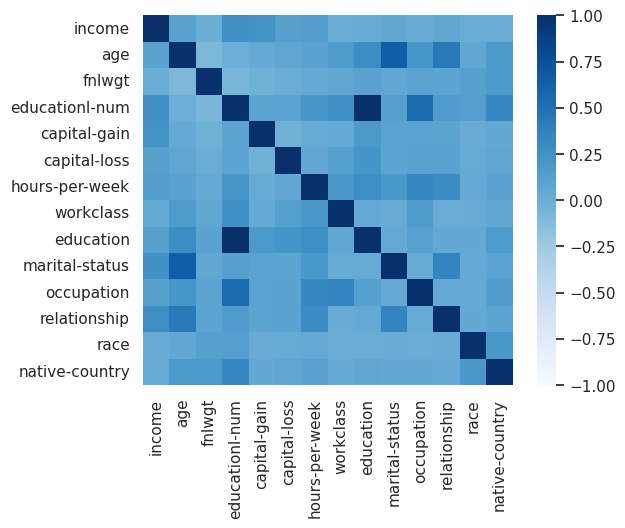

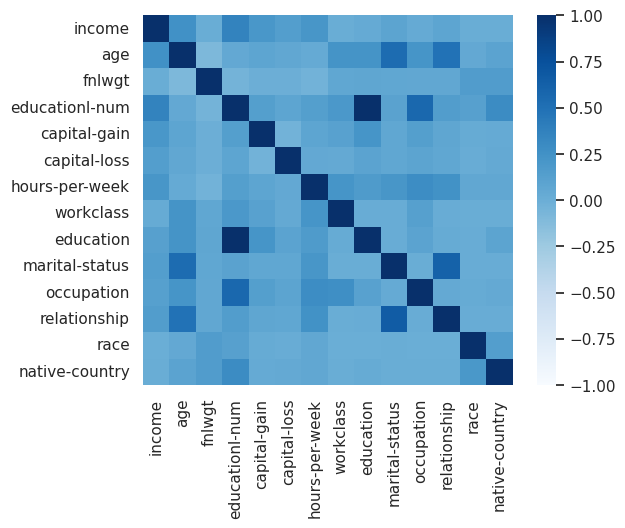

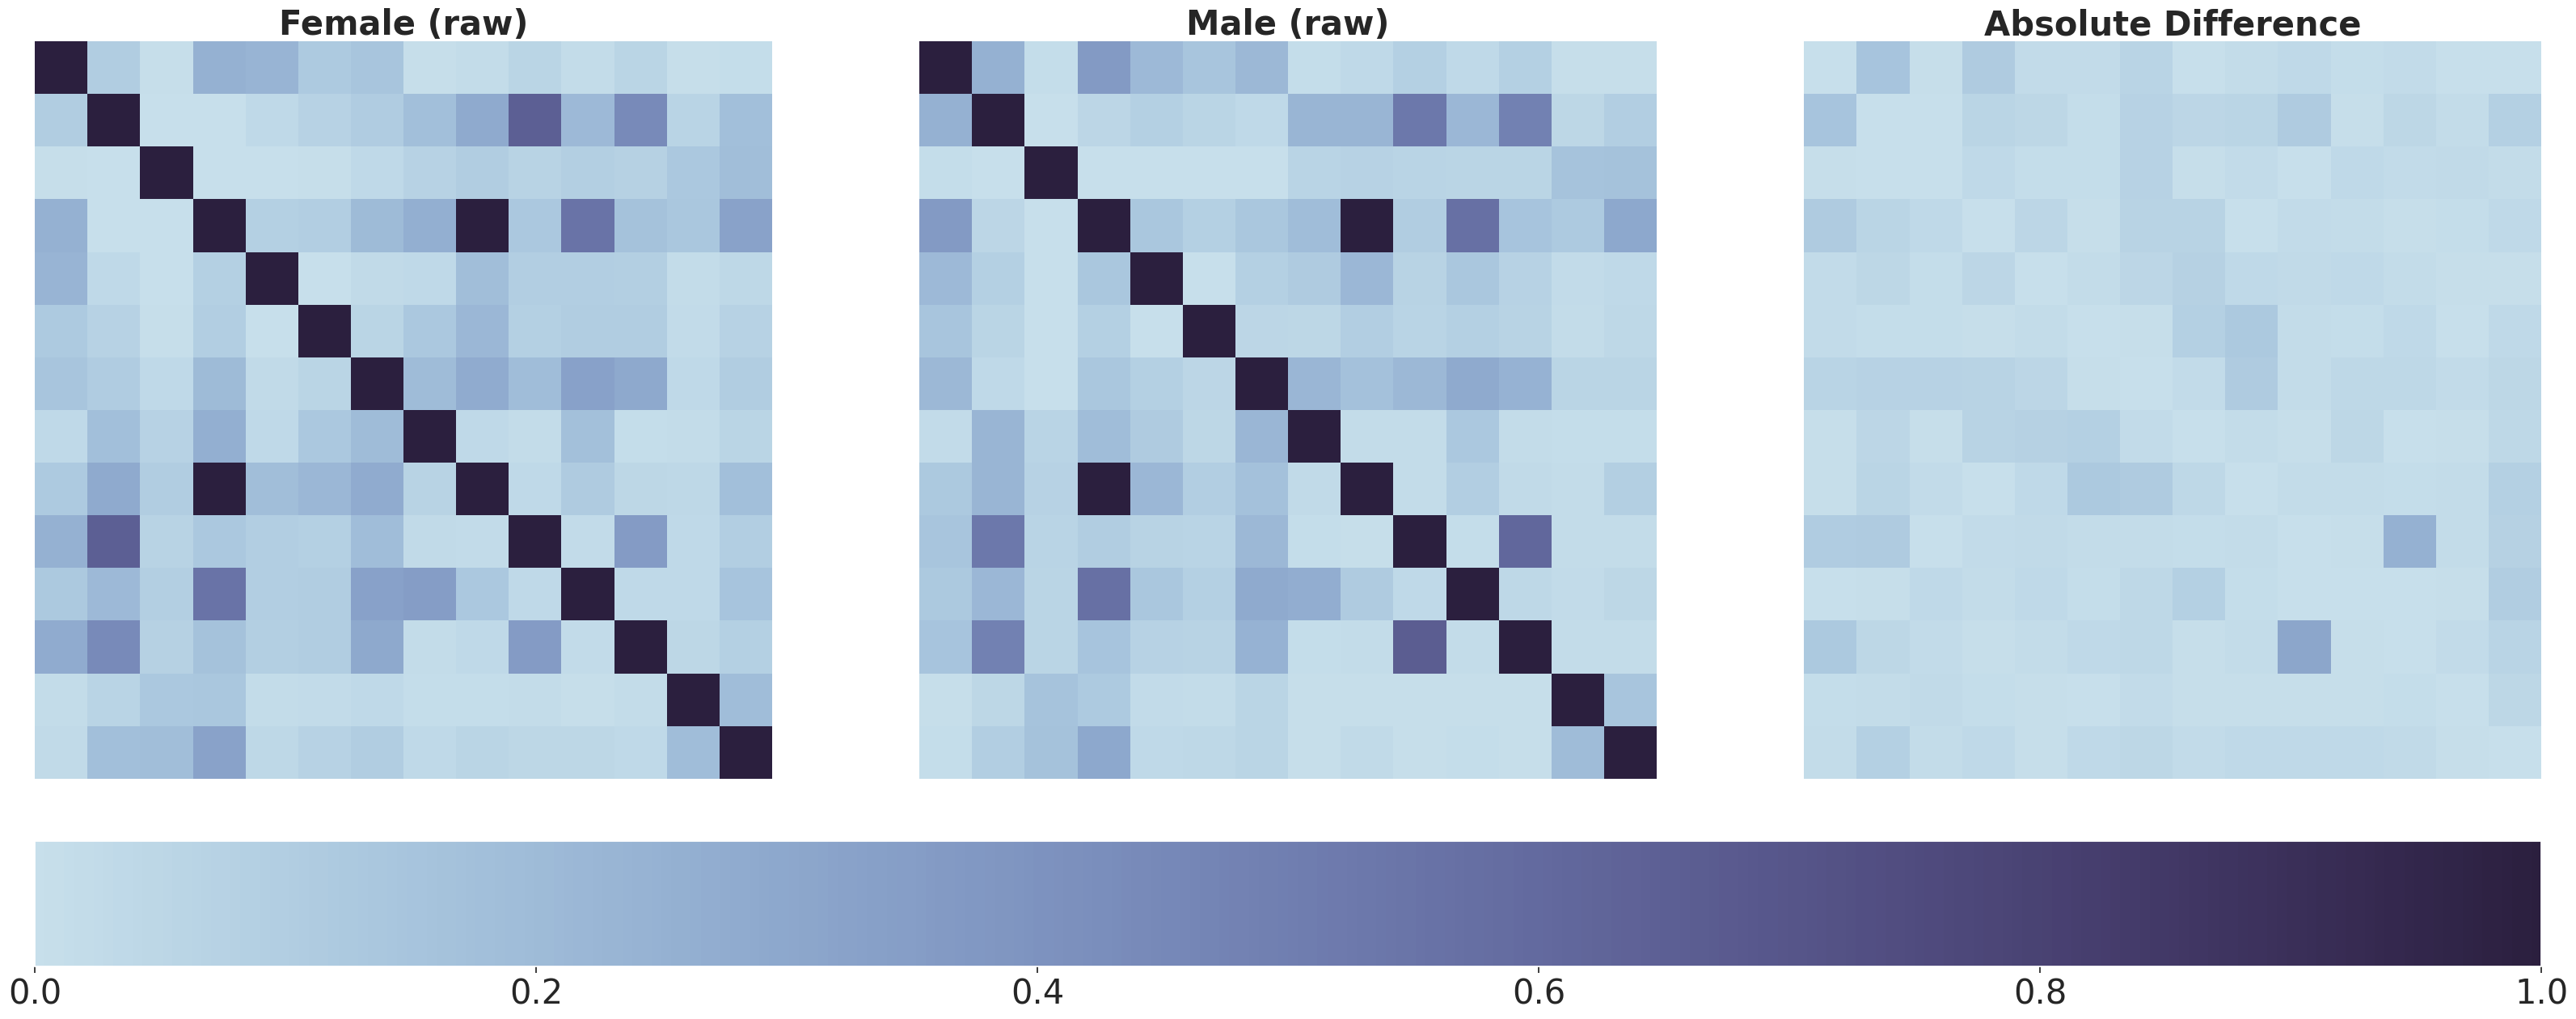

In [32]:
heatmap_correlation(female_df_twin1_test, male_df, "Female (raw)", "Male (raw)")

### Distribution metrics

In [19]:
# synethetic female sample from pre-trained model
synthetic_sample_dir = generate_sample(
    pipeline_config_path=f"{TDDPM_DIR}/exp/adult_female_pretraining_twin1/ddpm_cb_best/config.toml",
    ckpt_path=f"{TDDPM_DIR}/exp/adult_female_pretraining_twin1/ddpm_cb_best/model.pt",
    pipeline_dict_path=f"{TDDPM_DIR}/exp/adult_female_pretraining_twin1/ddpm_cb_best/pipeline_dict.joblib",
    num_samples=len(male_df),
    batch_size=len(male_df),
    device="cuda:0",
)
fake_female_df_pt = concat_data(synthetic_sample_dir, **gender_names_dict)
fake_female_df_pt["income"].cat.categories = ["0", "1"]

fake_female_df_pt.shape

Loading numerical preprocessing pipeline from /home/liu00980/Documents/multimodal/tabular/tab-ddpm//exp/adult_female_pretraining_twin1/ddpm_cb_best/pipeline_dict.joblib
Loading categorical preprocessing pipeline from /home/liu00980/Documents/multimodal/tabular/tab-ddpm//exp/adult_female_pretraining_twin1/ddpm_cb_best/pipeline_dict.joblib
Use category sizes from the loaded pipeline: [ 9 16  7 15  6  5 41]
mlp
Sample timestep    0
Discrete cols: [2, 4]
Num shape:  (32650, 6)


(32650, 14)

In [20]:
# synethetic female sample from fine-tuned model

synthetic_sample_dir = generate_sample(
    pipeline_config_path=f"{TDDPM_DIR}/exp/adult_female_{subset_size}_twin_1/ddpm_cb_best/config.toml",
    ckpt_path=f"{TDDPM_DIR}/exp/adult_female_{subset_size}_twin_1/ddpm_cb_best/model.pt",
    pipeline_dict_path=f"{TDDPM_DIR}/exp/adult_female_{subset_size}_twin_1/ddpm_cb_best/pipeline_dict.joblib",
    num_samples=len(male_df),
    batch_size=len(male_df),
    device="cuda:0",
)
fake_female_df = concat_data(synthetic_sample_dir, **gender_names_dict)
fake_female_df["income"].cat.categories = ["0", "1"]


fake_female_df.shape

Loading numerical preprocessing pipeline from /home/liu00980/Documents/multimodal/tabular/tab-ddpm//exp/adult_female_3000_twin_1/ddpm_cb_best/pipeline_dict.joblib
Loading categorical preprocessing pipeline from /home/liu00980/Documents/multimodal/tabular/tab-ddpm//exp/adult_female_3000_twin_1/ddpm_cb_best/pipeline_dict.joblib
Use category sizes from the loaded pipeline: [ 9 16  7 15  6  5 41]
mlp
Sample timestep    0
Discrete cols: [2, 4]
Num shape:  (32650, 6)


(32650, 14)

In [21]:
# synethetic male sample from pre-trained model

synthetic_sample_dir = generate_sample(
    pipeline_config_path=f"{TDDPM_DIR}/exp/adult_male/ddpm_cb_best/config.toml",
    ckpt_path=f"{TDDPM_DIR}/exp/adult_male/ddpm_cb_best/model.pt",
    pipeline_dict_path=f"{TDDPM_DIR}/exp/adult_male/ddpm_cb_best/pipeline_dict.joblib",
    num_samples=len(male_df),
    batch_size=len(male_df),
    device="cuda:0",
)
fake_male_df = concat_data(synthetic_sample_dir, **gender_names_dict)
fake_male_df["income"].cat.categories = ["0", "1"]

fake_male_df.shape

Loading numerical preprocessing pipeline from /home/liu00980/Documents/multimodal/tabular/tab-ddpm//exp/adult_male/ddpm_cb_best/pipeline_dict.joblib
Loading categorical preprocessing pipeline from /home/liu00980/Documents/multimodal/tabular/tab-ddpm//exp/adult_male/ddpm_cb_best/pipeline_dict.joblib
Use category sizes from the loaded pipeline: [ 9 16  7 15  6  5 41]
mlp
Sample timestep    0
Discrete cols: [2]
Num shape:  (32650, 6)


(32650, 14)

In [22]:
# test set of twin_1 data
female_df_twin1_test = concat_data(
    f"{TDDPM_DIR}/data/adult_female_{subset_size}_twin_1",
    split="test",
    **gender_names_dict,
)

In [23]:
# process the columns

fake_female_df_pt["source"] = "female_pretrained"
fake_female_df["source"] = "female_finetuned"
female_df_twin1_test["source"] = "female_raw"

temp_male_df = male_df.copy()
temp_male_df["source"] = "male_raw"
fake_male_df["source"] = "male_pretrained"


# quantile transformation for numerical features
for temp_df in [
    fake_female_df_pt,
    fake_female_df,
    female_df_twin1_test,
    temp_male_df,
    fake_male_df,
]:
    temp_df[gender_names_dict["num_features_list"]] = quantile_transform(
        temp_df[gender_names_dict["num_features_list"]],
        random_state=0,
        output_distribution="uniform",
    )

# one-hot encoding on categorical features (need to combine them all to get all levels presented in categorical variables)

temp_overall_df = pd.concat(
    [
        fake_female_df_pt,
        fake_female_df,
        female_df_twin1_test,
        temp_male_df,
        fake_male_df,
    ],
    axis=0,
    ignore_index=True,
)

temp_overall_df = pd.get_dummies(
    temp_overall_df,
    columns=[gender_names_dict["y_feature"]] + gender_names_dict["cat_features_list"],
)


pt_female_processed = temp_overall_df[temp_overall_df["source"] == "female_pretrained"].drop(columns=["source"])
ft_female_processed = temp_overall_df[temp_overall_df["source"] == "female_finetuned"].drop(columns=["source"])
raw_female_processed = temp_overall_df[temp_overall_df["source"] == "female_raw"].drop(columns=["source"])
raw_male_processed = temp_overall_df[temp_overall_df["source"] == "male_raw"].drop(columns=["source"])
pt_male_processed = temp_overall_df[temp_overall_df["source"] == "male_pretrained"].drop(columns=["source"])


print(pt_female_processed.shape)
print(ft_female_processed.shape)
print(raw_female_processed.shape)
print(raw_male_processed.shape)
print(pt_male_processed.shape)

(32650, 107)
(32650, 107)
(1350, 107)
(32650, 107)
(32650, 107)


In [26]:
comparison_df_list = [raw_male_processed, pt_male_processed, pt_female_processed, ft_female_processed]
comparison_names_list = ["Female (raw) V.S. Male (raw)", "Female (raw) V.S. Male (PT)", "Female (raw) V.S. Female (PT)", "Female (raw) V.S. Female (FT)"]

distance_list = []
for df_processed in comparison_df_list:
    fid_score = calculate_fid(df_processed, raw_female_processed)
    w1_distance = wasserstein_1_distance(df_processed, raw_female_processed)
    w2_distance = wasserstein_2_distance(df_processed, raw_female_processed)
    
    distance_list.append([fid_score, w1_distance, w2_distance])

pd.DataFrame(
    distance_list,
    index=comparison_names_list,
    columns=["FID (Gaussian)", "Wasserstein-1", "Wasserstein-2"],
)

,FID (Gaussian),Wassserstein-1,Wassserstein-2
Female (raw) V.S. Male (raw),1.971294,1.968028,2.124779
Female (raw) V.S. Male (PT),2.050636,1.967005,2.127329
Female (raw) V.S. Female (PT),0.456685,1.292332,1.536158
Female (raw) V.S. Female (FT),0.249286,1.170346,1.398779
